<h1> Final assignment description </h1>

The objective is to classify three different classes of ECG signals.
-<h4> Normal sinus rythm; </h4> 
![Normal sinus rythm](img/normal.PNG)
-<h4> Premature ventricular complex (PVC); </h4> 
![PAC](img/pvc.PNG)
-<h4> Premature atrial complex (PAC); </h4> 
![PVC](img/pac.PNG)


We must classify each beat of the signal and each beat of the training set is labelled with:
- N: normal sinus rythm; <br>
- S: supraventricular beats (PAC); <br>
- V: ventricular beats (PVC); <br>

<h2>Dataset </h2>

- 105 patients;
- fs: 128 or 250 Hz;
- 2 leads ECG -> 2 ecg signal for each patient; 
- Rpeaks are annotated in the dedicated .mat file;

File format: 
- [PatientID]\_[fs]+".mat" $\rightarrow$ 2 leads ECG signal;
- [PatientID]\_[fs]+\_[ann]+".mat" $\rightarrow$ labelling of the Rpeaks;
- [PatientID]\_[fs]+\_[rpk]+".mat" $\rightarrow$ Rpeaks location in the signal (at which time an Rpeak appears);

In [1]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import keras
import tensorflow as tf 
import sys

In [2]:
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)


<h2>Load the dataset</h2>

In [6]:
from utils.data_loading import load_data

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

print(rpeaks)

<h2>Data visualization</h2>

In [70]:

def plot_signal(sigID,length,peakNum):

    """
    Plot first & second lead ecg signal for a fixed length, centered at indexed peak
    """
    peak = rpeaks[sigID][peakNum]
    signal = np.asarray(ecg_signals[sigID]).astype(np.float32)

    x = list()

    range_ = range(int(peak-length/2),int(peak+length/2))
    for r in range_:
        if(r >= 0):
            x.append(r)

    y_first_lead = signal[x,0]
    y_second_lead = signal[x,1]
    fig, axs = plt.subplots(2)

    axs[0].set_title(label="First and second lead")
    
    axs[0].plot(x, y_first_lead, linewidth=2.0)
    axs[1].plot(x,y_second_lead,linewidth=2.0)


    #we are plotting only the defined time, so we must count how many peaks 
    indexes = list()
    
    for i,p in enumerate(rpeaks[sigID]):
        if (p >= peak-length/2 and p <= peak + length/2):
            indexes.append(i)
    
    x = rpeaks[sigID][indexes]  # time values of the peaks in between the defined length 
    y_first = ecg_signals[sigID][x,0]         # amplitude value of the peaks for first lead 
    y_second = ecg_signals[sigID][x,1]
    
    axs[0].scatter(x,y_first,color = "red")
    axs[1].scatter(x,y_second,color = "red")

    peaks_labels = labels[sigID][indexes] 
    offset = 15
    for i,label in enumerate(peaks_labels):
        axs[0].annotate(label,(x[i]-offset,y_first[i]),fontsize = "large")
        axs[1].annotate(label,(x[i]-offset,y_second[i]),fontsize = "large")

    plt.show()
    

Visualize examples of beats for each class

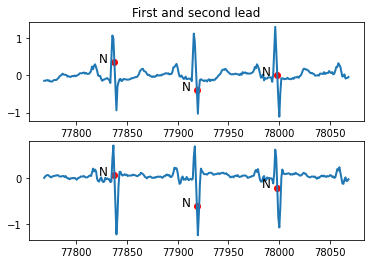

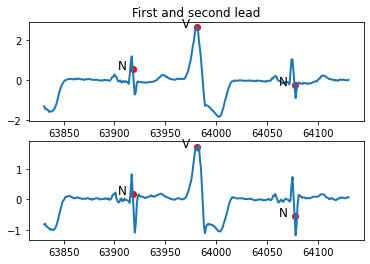

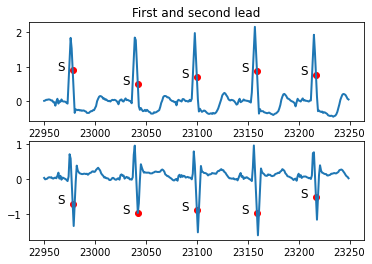

In [72]:
n_index = list()
v_index = list()
s_index = list()
sigID_N = 0
sigID_V = 0
sigID_S = 0

for i,label in enumerate(labels):
    res = np.where(label == "N")
    if (len(res) != 0):
        sigID_N = i
        n_index = res[0]
        break
for i,label in enumerate(labels):
    res = np.where(label == "V")
    if (len(res) != 0):
        sigID_V = i
        v_index = res[0] 
        break
for i,label in enumerate(labels):
    res = np.where(label == "S")
    if (len(res) != 0):
        sigID_S = i
        s_index = res[0] 
        break



plot_signal(sigID_N,300,n_index[int(len(n_index)/3)])
plot_signal(sigID_V,300,v_index[int(len(v_index)/3)])
plot_signal(sigID_S,300,s_index[int(len(s_index)/3)])

<h2> Problem: Class imbalance </h2>
This must be addressed in a proper way.

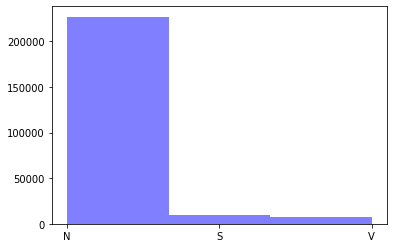

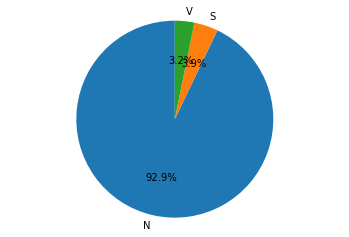

N beats samples: 226932
S beats samples: 9609
V beats samples: 7795


In [78]:
def count_classes(labels,classes):
    
    counts = [0]*len(classes)

    for i,k in enumerate(classes): # iterate over the classes is not the most efficient one, but it's more readable at the end 
        for label in labels:
            counts[i] += len(np.where(label == k)[0])

    return counts

classes = ["N","S","V"]

x = list()
counts = count_classes(labels,classes)

for i,k in enumerate(classes):
    x.extend([k]*counts[i])

num_bins = len(classes)
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

print(f"N beats samples: {counts[0]}")
print(f"S beats samples: {counts[1]}")
print(f"V beats samples: {counts[2]}")

<h2>Create dataframe</h2>
Pandas dataframe allows to manage data easily

In [104]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols
df


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[[29], [110], [191], [272], [353], [433], [514...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[[48], [153], [243], [352], [440], [547], [636...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[[91], [209], [326], [394], [537], [653], [745...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[[98], [223], [349], [474], [599], [726], [853...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[[27], [127], [225], [324], [423], [523], [623...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[-0.22, -0.225, -0.23, -0.22, -0.185, -0.155, ...","[-0.86, -0.905, -0.94, -0.975, -1.0, -1.025, -...","[[155], [383], [611], [835], [1053], [1275], [...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.385, 0.35, 0.31, 0.285, 0.265, 0.25, 0.225,...","[0.515, 0.45, 0.38, 0.33, 0.3, 0.28, 0.25, 0.2...","[[215], [437], [667], [823], [1119], [1349], [...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[-0.12, -0.12, -0.12, -0.125, -0.12, -0.115, -...","[-0.1, -0.105, -0.11, -0.125, -0.135, -0.13, -...","[[255], [535], [817], [1093], [1377], [1657], ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[-0.045, -0.045, -0.045, -0.045, -0.045, -0.04...","[0.175, 0.185, 0.18, 0.175, 0.175, 0.175, 0.17...","[[19], [295], [575], [863], [1151], [1435], [1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [22]:
# dataset needs to be created because we need to classify beats and not the entire signal 

classes = np.array(["N","S","V"])

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)



dataset = dict()
length = 170

for l,id in enumerate(ids):
    for i,peak in enumerate(rpeaks):
        
        dataset[id+"_"+str(i)] = {}
        dataset[id+"_"+str(i)]["first_lead"] = list()
        dataset[id+"_"+str(i)]["second_lead"] = list()
        p = peak[0]

        for s in range(int(p-length/2),int(p+length/2)):

            if(s < 0 or s >= len(first_lead_signals[l])):   # padding with 0
                dataset[id+"_"+str(i)]["first_lead"].append(0.) 
                dataset[id+"_"+str(i)]["second_lead"].append(0.) 
            else:
                dataset[id+"_"+str(i)]["first_lead"].append(first_lead_signals[l][s])
                dataset[id+"_"+str(i)]["second_lead"].append(first_lead_signals[l][s])

        dataset[id+"_"+str(i)]["label"] = convert_to_one_hot(labels[l][i])

dataset_df = pd.DataFrame.from_dict(dataset,orient="index")

dataset_df

is_NaN = dataset_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = dataset_df[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [first_lead, second_lead, label]
Index: []


In [53]:
# TRAIN ARRAYS

x_train_ = dataset_df[['first_lead','second_lead']].values 
y_train = dataset_df['label'].values
x_train = list()

for x in x_train_:
    x_train.append(x[0] + x[1])

y_ = np.array([np.array(yi) for yi in y_train])
x_=np.array([np.array(xi) for xi in x_train])

In [55]:
print(f"samples: {len(x_train)}")
print(f"Input size: {len(x_train[0])}")
#print(f"Input : {x_train[0]}")
print(f"Labels: {y_.shape}")
print(f"X_train shape: {x_.shape}")

print(x_[0])
print(y_[0])

x_ = np.asarray(x_).astype(np.float32)
y_ = np.asarray(y_).astype(np.float32)

samples: 11025
Input size: 340
Labels: (11025, 3)
X_train shape: (11025, 340)
[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.04   0.03   0.
  0.03   0.09   0.18   0.14   0.3    0.24   0.2    0.05  -0.02  -0.02
 -0.05  -0.11  -0.11  -0.1   -0.14  -0.14  -0.12  -0.13  -0.08  -0.16
  0.19   0.825  1.46   2.095  1.455  0.815  0.175 -0.42  -0.26  -0.29
 -0.29  -0.31  -0.26  -0.29  -0.3   -0.32  -0.31  -0.32  -0.31  -0.26
 -0.27  -0.27  -0.28  -0.26  -0.25  -0.22  -0.16  -0.14  -0.06  -0.02
  0.05   0.1    0.16   0.15   0.13   0.12   0.09   0.05   0.03   0.05
  0.03   0.03   0.02   0.     0.02   0.     0.04   0.02   0.03   0.04
  0.03   0.04   0.04   0

In [59]:

def neuralNet():
    return keras.Sequential([
    keras.layers.Input(shape = (340,)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(3,activation=tf.nn.softmax)
])

nn = neuralNet()
nn.summary()

learning_rate = 0.0025
nn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = nn.fit(
    x = x_,
    y = y_, 
    batch_size = 1,
    #validation_data=(x_valid, y_valid),
    epochs = 10
).history

#validation_data=(X_val_filt, y_val),

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 256)               87296     
                                                                 
 dense_40 (Dense)            (None, 512)               131584    
                                                                 
 dense_41 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 220,419
Trainable params: 220,419
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
11025/11025 [==============================] - 8s 686us/step - loss: 0.4552 - accuracy: 0.9218
Epoch 2/10
11025/11025 [==============================] - 8s 737us/step - loss: 0.4882 - accuracy: 0.9155
Epoch 3/10
11025/11025 [==============================] - 7s 657us/step - loss: 0.4580 - accuracy: 